# **Training for ResNet50**


In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Libraries to import**

In [ ]:
import os
import cv2
import shutil
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from PIL import Image


# **Data Preproccessing**

In [1]:
# Organizing Datasets
def create_directory_structure(base_path):
    folders = [
        "train/images", "train/labels",
        "val/images", "val/labels",
        "test/images", "test/labels",
        "unlabeled/images"
    ]
    for folder in folders:
        os.makedirs(os.path.join(base_path, folder), exist_ok=True)
        
    return folders # Returns the list of created folder paths

# Applying Data augmentation
def adjust_annotations(annotations, crop_x, crop_y, crop_w, crop_h, orig_w, orig_h):
    """Adjust bounding box annotations after cropping."""
    new_annotations = []
    for line in annotations:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        x_abs, y_abs = x_center * orig_w, y_center * orig_h
        width, height = width * orig_w, height * orig_h
        
        x1, y1 = x_abs - width / 2, y_abs - height / 2
        x2, y2 = x_abs + width / 2, y_abs + height / 2
        
        if x1 >= crop_x and y1 >= crop_y and x2 <= crop_x + crop_w and y2 <= crop_y + crop_h:
            x1_new, y1_new = x1 - crop_x, y1 - crop_y
            x2_new, y2_new = x2 - crop_x, y2 - crop_y
            x_center_new = (x1_new + x2_new) / 2 / crop_w
            y_center_new = (y1_new + y2_new) / 2 / crop_h
            width_new = (x2_new - x1_new) / crop_w
            height_new = (y2_new - y1_new) / crop_h
            new_annotations.append(f"{class_id} {x_center_new:.6f} {y_center_new:.6f} {width_new:.6f} {height_new:.6f}")
    return new_annotations

def random_crop(image, annotations, crop_size=(224, 224)):
    """Randomly cropping image and adjusting annotations."""
    h, w, _ = image.shape
    crop_h, crop_w = crop_size
    if crop_h > h or crop_w > w:
        return image, annotations
    x_start = random.randint(0, w - crop_w)
    y_start = random.randint(0, h - crop_h)
    cropped_image = image[y_start:y_start + crop_h, x_start:x_start + crop_w]
    new_annotations = adjust_annotations(annotations, x_start, y_start, crop_w, crop_h, w, h)
    return cropped_image, new_annotations

def invert_colors(image):
    """Inverting image colors."""
    return cv2.bitwise_not(image)

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    """Applying Gaussian blur to image."""
    return cv2.GaussianBlur(image, kernel_size, 0)
    
def process_training_set(train_orig, source_paths, dest_paths, augment=True):
    """Processing training set with optional augmentation."""
    processed_count = 0
    augmented_count = 0
    
    for img_name in tqdm(train_orig, desc="Processing training images"):
        img_path = os.path.join(source_paths['images'], img_name)
        ann_path = os.path.join(source_paths['annotations'], img_name.replace(".jpg", ".txt"))
        
        if not os.path.exists(ann_path):
            continue
        
        image = cv2.imread(img_path)
        with open(ann_path, "r") as f:
            annotations = f.readlines()
        
        # Copy original
        shutil.copy(img_path, os.path.join(dest_paths['images'], img_name))
        shutil.copy(ann_path, os.path.join(dest_paths['labels'], img_name.replace(".jpg", ".txt")))
        processed_count += 1
        
        if augment:
            # Generate augmentations
            augmentations = [
                random_crop(image, annotations),
                (invert_colors(image), annotations),
                (apply_gaussian_blur(image), annotations)
            ]
            
            for i, (aug_img, aug_ann) in enumerate(augmentations):
                aug_img_name = f"aug_{i}_{img_name}"
                aug_ann_name = f"aug_{i}_{img_name.replace('.jpg', '.txt')}"
                cv2.imwrite(os.path.join(dest_paths['images'], aug_img_name), aug_img)
                with open(os.path.join(dest_paths['labels'], aug_ann_name), "w") as f:
                    f.write("\n".join(aug_ann))
                augmented_count += 1
                
    return processed_count, augmented_count

def process_unlabeled_set(unlabeled_images, source_paths, dest_paths):
    """ Process unlabeled images (without annotations). """
    processed_count = 0
    
    for img_name in tqdm(unlabeled_images, desc="Processing unlabeled images"):
        img_path = os.path.join(source_paths['unlabeled_images'], img_name)  # Corrected this path
        if not os.path.exists(img_path):
            continue
        
        # Copy original image to unlabeled folder
        shutil.copy(img_path, os.path.join(dest_paths['images'], img_name))
        processed_count += 1
    
    return processed_count

# Data Splitting and Statistics 
def process_dataset_split(image_list, source_paths, dest_paths, split_name=""):
    """Process dataset split (validation or test)."""
    processed_count = 0
    for img_name in tqdm(image_list, desc=f"Processing {split_name} images"):
        img_path = os.path.join(source_paths['images'], img_name)
        ann_path = os.path.join(source_paths['annotations'], img_name.replace(".jpg", ".txt"))
        
        if not os.path.exists(ann_path):
            continue
        
        shutil.copy(img_path, os.path.join(dest_paths['images'], img_name))
        shutil.copy(ann_path, os.path.join(dest_paths['labels'], img_name.replace(".jpg", ".txt")))
        processed_count += 1
    
    return processed_count

def get_dir_size(path):
    """Get directory size in MB."""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024) 

def main():
    # Defining paths for accessing dataset on kaggle
    base_path = "/kaggle/input/weedzip"
    source_paths = {
        'labeled_images': os.path.join(base_path, "labeled/images"),
        'labeled_annotations': os.path.join(base_path, "labeled/annotations"),
        'test_images': os.path.join(base_path, "test/images"),
        'test_annotations': os.path.join(base_path, "test/annotations"),
        'unlabeled_images': os.path.join(base_path, "unlabeled")
    }
    
    preprocessed_path = "/kaggle/working/Preprocessed_img_weed"
    folders = create_directory_structure(preprocessed_path)
    
    # Split original dataset
    all_original_images = os.listdir(source_paths['labeled_images'])
    train_orig, val_orig = train_test_split(all_original_images, test_size=0.2, random_state=42)
    
    # Split unlabeled dataset
    unlabeled_images = os.listdir(source_paths['unlabeled_images'])
    
    # Print initial statistics
    print("\nOriginal dataset statistics:")
    print(f"Total original images: {len(all_original_images)}")
    print(f"Training images before augmentation: {len(train_orig)}")
    print(f"Validation images: {len(val_orig)}")
    print(f"Unlabeled images: {len(unlabeled_images)}")
    
    # Process training set
    train_paths = {
        'images': os.path.join(preprocessed_path, "train/images"),
        'labels': os.path.join(preprocessed_path, "train/labels")
    }
    processed_train, augmented_count = process_training_set(
        train_orig,
        {'images': source_paths['labeled_images'], 'annotations': source_paths['labeled_annotations']},
        train_paths
    )
    
    # Process validation set
    val_paths = {
        'images': os.path.join(preprocessed_path, "val/images"),
        'labels': os.path.join(preprocessed_path, "val/labels")
    }
    processed_val = process_dataset_split(
        val_orig,
        {'images': source_paths['labeled_images'], 'annotations': source_paths['labeled_annotations']},
        val_paths,
        "validation"
    )
    
    # Process test set
    test_paths = {
        'images': os.path.join(preprocessed_path, "test/images"),
        'labels': os.path.join(preprocessed_path, "test/labels")
    }
    processed_test = process_dataset_split(
        os.listdir(source_paths['test_images']),
        {'images': source_paths['test_images'], 'annotations': source_paths['test_annotations']},
        test_paths,
        "test"
    )
    
    # Process unlabeled set
    unlabeled_paths = {
        'images': os.path.join(preprocessed_path, "unlabeled/images")
    }
    if not os.path.exists(unlabeled_paths['images']):
        os.makedirs(unlabeled_paths['images'])
    
    processed_unlabeled = process_unlabeled_set(
        unlabeled_images,
        {'unlabeled_images': source_paths['unlabeled_images']},
        unlabeled_paths
    )
    
    # Print comprehensive dataset statistics
    print("\nFinal dataset statistics:")
    print("\nImage counts:")
    print(f"Training images (original): {processed_train}")
    print(f"Training images (augmented): {augmented_count}")
    print(f"Training images (total): {processed_train + augmented_count}")
    print(f"Validation images: {processed_val}")
    print(f"Test images: {processed_test}")
    print(f"Unlabeled images: {processed_unlabeled}")
    
    print("\nDataset sizes:")
    print(f"Training set size: {get_dir_size(os.path.join(preprocessed_path, 'train')):.2f} MB")
    print(f"Validation set size: {get_dir_size(os.path.join(preprocessed_path, 'val')):.2f} MB")
    print(f"Test set size: {get_dir_size(os.path.join(preprocessed_path, 'test')):.2f} MB")
    print(f"Unlabeled set size: {get_dir_size(os.path.join(preprocessed_path, 'unlabeled')):.2f} MB")
    print(f"Total dataset size: {get_dir_size(preprocessed_path):.2f} MB")
    
    print("\nFiles per directory:")
    for folder in folders:
        path = os.path.join(preprocessed_path, folder)
        print(f"{folder}: {len(os.listdir(path))} files")

if __name__ == "__main__":
    main()



Original dataset statistics:
Total original images: 200
Training images before augmentation: 160
Validation images: 40
Unlabeled images: 1000


Processing unlabeled images: 100%|██████████| 1000/1000 [00:07<00:00, 126.84it/s]


Final dataset statistics:

Image counts:
Training images (original): 160
Training images (augmented): 480
Training images (total): 640
Validation images: 40
Test images: 50
Unlabeled images: 1000

Dataset sizes:
Training set size: 46.38 MB
Validation set size: 2.52 MB
Test set size: 3.08 MB
Unlabeled set size: 60.48 MB
Total dataset size: 112.47 MB

Files per directory:
train/images: 640 files
train/labels: 640 files
val/images: 40 files
val/labels: 40 files
test/images: 50 files
test/labels: 50 files
unlabeled/images: 1000 files


# **Data Training**

In [7]:

# Accessing the preproceesd dataset for training
PREPROCESSED_PATH = r"/kaggle/working/Preprocessed_img_weed"

# Class for loading weed classification images and labels.
class WeedDataset(Dataset):
    def __init__(self, image_dir, label_dir=None, transform=None, is_unlabeled=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.is_unlabeled = is_unlabeled
        self.image_files = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.image_files)
    
    def read_label_file(self, label_path):
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
                # Filter out empty lines and whitespace
                lines = [line.strip() for line in lines if line.strip()]
                
                if not lines:
                    return 1 
                
                for line in lines:
                    parts = line.split()
                    if parts and parts[0] == '0': 
                        return 0  # Weed
                return 1  # Crop
        except Exception as e:
            print(f"Error reading label file {label_path}: {str(e)}")
            return 1  # Default to crop in case of errors
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Create a blank image in case of error
            image = Image.new('RGB', (224, 224))
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_unlabeled:
            return image.to(device)
            
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))
        label = torch.tensor(self.read_label_file(label_path))
            
        return image.to(device), label.to(device)
    
#                          * MEAN TEACHER METHOD (MTM) OVERVIEW *

# Implementing a semi-supervised learning approach for weed detection using a Student-teacher framework with ResNet-50.
#
#  - The **student model** learns from both labeled and pseudo-labeled data.
#  - The **teacher model** provides pseudo-labels for unlabeled data.
#  - The teacher model is updated using **Exponential Moving Average (EMA)

class SemiSupervisedWeedDetector:
    def __init__(self, confidence_threshold=0.85):
        self.student_model = self._create_model().to(device)
        self.teacher_model = self._create_model().to(device)
        self.confidence_threshold = confidence_threshold
        self.ema_decay = 0.999
        
    def _create_model(self):
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 2)
        return model
        
    def update_teacher(self):
        for teacher_param, student_param in zip(self.teacher_model.parameters(), 
                                                self.student_model.parameters()):
            teacher_param.data = self.ema_decay * teacher_param.data + (1 - self.ema_decay) * student_param.data
    
    def train_step(self, labeled_batch, unlabeled_batch):
        images, labels = labeled_batch
        unlabeled_images = unlabeled_batch
        
        outputs = self.student_model(images)
        supervised_loss = nn.CrossEntropyLoss()(outputs, labels)
        
        with torch.no_grad():
            pseudo_logits = self.teacher_model(unlabeled_images)
            pseudo_probs = torch.softmax(pseudo_logits, dim=1)
            confidence, pseudo_labels = torch.max(pseudo_probs, dim=1)
        
        mask = confidence > self.confidence_threshold
        
        if mask.sum() > 0:
            unsupervised_loss = nn.CrossEntropyLoss()(self.student_model(unlabeled_images[mask]), pseudo_labels[mask])
        else:
            unsupervised_loss = torch.tensor(0.0).to(device)
        
        total_loss = supervised_loss + unsupervised_loss
        return total_loss
    
    def train(self, labeled_loader, unlabeled_loader, val_loader, num_epochs=100):
        optimizer = torch.optim.AdamW(self.student_model.parameters(), lr=1e-4)
        best_val_acc = 0
        
        for epoch in range(num_epochs):
            self.student_model.train()
            epoch_loss = 0
            correct, total = 0, 0
            
            pbar = tqdm(zip(labeled_loader, unlabeled_loader), total=min(len(labeled_loader), len(unlabeled_loader)))
            for labeled_batch, unlabeled_batch in pbar:
                optimizer.zero_grad()
                loss = self.train_step(labeled_batch, unlabeled_batch)
                loss.backward()
                optimizer.step()
                self.update_teacher()
                epoch_loss += loss.item()
                
                images, labels = labeled_batch
                outputs = self.student_model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                pbar.set_description(f"Epoch {epoch+1}")
            
            train_acc = 100 * correct / total
            val_acc = self.evaluate(val_loader)
            
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(labeled_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.student_model.state_dict(), 'best_model.pth')
                print("Best model saved!")
    
    def evaluate(self, loader):
        self.student_model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for images, labels in loader:
                outputs = self.student_model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        return 100 * correct / total
#-------------------------------------------------------------------------------------

# Define transformations for training data

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = WeedDataset(os.path.join(PREPROCESSED_PATH, "train/images"), os.path.join(PREPROCESSED_PATH, "train/labels"), train_transform)
val_dataset = WeedDataset(os.path.join(PREPROCESSED_PATH, "val/images"), os.path.join(PREPROCESSED_PATH, "val/labels"), val_transform)
unlabeled_dataset = WeedDataset(os.path.join(PREPROCESSED_PATH, "unlabeled/images"), transform=train_transform, is_unlabeled=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32)

# Initialize and train the model
model = SemiSupervisedWeedDetector()
model.train(train_loader, unlabeled_loader, val_loader, num_epochs=100)

Using device: cuda


Epoch 1: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 1, Loss: 0.4312, Train Acc: 97.97%, Val Acc: 95.00%
Best model saved!


Epoch 2: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 2, Loss: 0.1179, Train Acc: 98.59%, Val Acc: 95.00%


Epoch 3: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 3, Loss: 0.0735, Train Acc: 99.06%, Val Acc: 95.00%


Epoch 4: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch 4, Loss: 0.0310, Train Acc: 99.53%, Val Acc: 95.00%


Epoch 5: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 5, Loss: 0.0267, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 6: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 6, Loss: 0.0271, Train Acc: 99.53%, Val Acc: 95.00%


Epoch 7: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 7, Loss: 0.0246, Train Acc: 99.53%, Val Acc: 95.00%


Epoch 8: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 8, Loss: 0.0157, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 9: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch 9, Loss: 0.0282, Train Acc: 99.38%, Val Acc: 97.50%
Best model saved!


Epoch 10: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 10, Loss: 0.0167, Train Acc: 99.53%, Val Acc: 95.00%


Epoch 11: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 11, Loss: 0.0141, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 12: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 12, Loss: 0.0311, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 13: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 13, Loss: 0.0168, Train Acc: 99.38%, Val Acc: 95.00%


Epoch 14: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 14, Loss: 0.0101, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 15: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 15, Loss: 0.0095, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 16: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 16, Loss: 0.0089, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 17: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch 17, Loss: 0.0087, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 18: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 18, Loss: 0.0081, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 19: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 19, Loss: 0.0060, Train Acc: 100.00%, Val Acc: 92.50%


Epoch 20: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch 20, Loss: 0.0076, Train Acc: 99.84%, Val Acc: 92.50%


Epoch 21: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 21, Loss: 0.0169, Train Acc: 99.84%, Val Acc: 92.50%


Epoch 22: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 22, Loss: 0.0129, Train Acc: 99.84%, Val Acc: 90.00%


Epoch 23: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 23, Loss: 0.0120, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 24: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 24, Loss: 0.0170, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 25: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch 25, Loss: 0.0694, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 26: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch 26, Loss: 0.0614, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 27: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch 27, Loss: 0.0404, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 28: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch 28, Loss: 0.0247, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 29: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch 29, Loss: 0.0405, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 30: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch 30, Loss: 0.0296, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 31: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Epoch 31, Loss: 0.0389, Train Acc: 99.69%, Val Acc: 90.00%


Epoch 32: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch 32, Loss: 0.0150, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 33: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch 33, Loss: 0.0158, Train Acc: 99.38%, Val Acc: 90.00%


Epoch 34: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch 34, Loss: 0.0206, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 35: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch 35, Loss: 0.0157, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 36: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch 36, Loss: 0.0313, Train Acc: 99.53%, Val Acc: 87.50%


Epoch 37: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch 37, Loss: 0.0208, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 38: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch 38, Loss: 0.0114, Train Acc: 100.00%, Val Acc: 90.00%


Epoch 39: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch 39, Loss: 0.0220, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 40: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch 40, Loss: 0.0351, Train Acc: 99.84%, Val Acc: 92.50%


Epoch 41: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch 41, Loss: 0.0343, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 42: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch 42, Loss: 0.0208, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 43: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch 43, Loss: 0.0218, Train Acc: 99.69%, Val Acc: 90.00%


Epoch 44: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch 44, Loss: 0.0124, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 45: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch 45, Loss: 0.0108, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 46: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch 46, Loss: 0.0381, Train Acc: 99.22%, Val Acc: 90.00%


Epoch 47: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch 47, Loss: 0.0424, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 48: 100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


Epoch 48, Loss: 0.0278, Train Acc: 100.00%, Val Acc: 92.50%


Epoch 49: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch 49, Loss: 0.0149, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 50: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch 50, Loss: 0.0105, Train Acc: 99.84%, Val Acc: 92.50%


Epoch 51: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch 51, Loss: 0.0084, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 52: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch 52, Loss: 0.0129, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 53: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch 53, Loss: 0.0557, Train Acc: 99.22%, Val Acc: 92.50%


Epoch 54: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 54, Loss: 0.0281, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 55: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch 55, Loss: 0.0227, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 56: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch 56, Loss: 0.0198, Train Acc: 100.00%, Val Acc: 92.50%


Epoch 57: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch 57, Loss: 0.0129, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 58: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 58, Loss: 0.0108, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 59: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch 59, Loss: 0.0124, Train Acc: 99.38%, Val Acc: 90.00%


Epoch 60: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch 60, Loss: 0.0084, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 61: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch 61, Loss: 0.0082, Train Acc: 99.22%, Val Acc: 92.50%


Epoch 62: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch 62, Loss: 0.0072, Train Acc: 99.84%, Val Acc: 92.50%


Epoch 63: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 63, Loss: 0.0117, Train Acc: 99.69%, Val Acc: 90.00%


Epoch 64: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch 64, Loss: 0.0114, Train Acc: 99.38%, Val Acc: 90.00%


Epoch 65: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 65, Loss: 0.0100, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 66: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch 66, Loss: 0.0081, Train Acc: 99.69%, Val Acc: 92.50%


Epoch 67: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 67, Loss: 0.0114, Train Acc: 99.38%, Val Acc: 92.50%


Epoch 68: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epoch 68, Loss: 0.0094, Train Acc: 99.69%, Val Acc: 90.00%


Epoch 69: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 69, Loss: 0.0204, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 70: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 70, Loss: 0.0128, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 71: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 71, Loss: 0.0104, Train Acc: 99.84%, Val Acc: 90.00%


Epoch 72: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 72, Loss: 0.0084, Train Acc: 99.84%, Val Acc: 90.00%


Epoch 73: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Epoch 73, Loss: 0.0068, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 74: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 74, Loss: 0.0149, Train Acc: 99.53%, Val Acc: 90.00%


Epoch 75: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 75, Loss: 0.0275, Train Acc: 99.84%, Val Acc: 90.00%


Epoch 76: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 76, Loss: 0.0250, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 77: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 77, Loss: 0.0563, Train Acc: 99.22%, Val Acc: 92.50%


Epoch 78: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch 78, Loss: 0.0373, Train Acc: 99.53%, Val Acc: 92.50%


Epoch 79: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 79, Loss: 0.0157, Train Acc: 99.84%, Val Acc: 87.50%


Epoch 80: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 80, Loss: 0.0247, Train Acc: 99.53%, Val Acc: 87.50%


Epoch 81: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 81, Loss: 0.0287, Train Acc: 99.84%, Val Acc: 87.50%


Epoch 82: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 82, Loss: 0.0221, Train Acc: 99.69%, Val Acc: 90.00%


Epoch 83: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 83, Loss: 0.0180, Train Acc: 99.53%, Val Acc: 87.50%


Epoch 84: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch 84, Loss: 0.0138, Train Acc: 99.53%, Val Acc: 87.50%


Epoch 85: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 85, Loss: 0.0172, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 86: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 86, Loss: 0.0252, Train Acc: 99.53%, Val Acc: 87.50%


Epoch 87: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 87, Loss: 0.0101, Train Acc: 99.53%, Val Acc: 87.50%


Epoch 88: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 88, Loss: 0.0080, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 89: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch 89, Loss: 0.0086, Train Acc: 99.38%, Val Acc: 87.50%


Epoch 90: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 90, Loss: 0.0185, Train Acc: 99.38%, Val Acc: 87.50%


Epoch 91: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 91, Loss: 0.0212, Train Acc: 99.84%, Val Acc: 87.50%


Epoch 92: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 92, Loss: 0.0210, Train Acc: 99.84%, Val Acc: 87.50%


Epoch 93: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 93, Loss: 0.0263, Train Acc: 99.84%, Val Acc: 87.50%


Epoch 94: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 94, Loss: 0.0346, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 95: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch 95, Loss: 0.0403, Train Acc: 99.84%, Val Acc: 87.50%


Epoch 96: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 96, Loss: 0.0225, Train Acc: 99.69%, Val Acc: 90.00%


Epoch 97: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch 97, Loss: 0.0366, Train Acc: 99.69%, Val Acc: 87.50%


Epoch 98: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch 98, Loss: 0.0134, Train Acc: 99.53%, Val Acc: 87.50%


Epoch 99: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch 99, Loss: 0.0164, Train Acc: 99.84%, Val Acc: 87.50%


Epoch 100: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


Epoch 100, Loss: 0.0135, Train Acc: 99.69%, Val Acc: 87.50%


# **Data Testing**

In [8]:
MODEL_SAVE_PATH = "semi_supervised_weed_model.pth"
torch.save(model.student_model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved at {MODEL_SAVE_PATH}")

Model saved at semi_supervised_weed_model.pth


<ipython-input-11-ea01e88b1ed1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.student_model.load_state_dict(torch.load(r'/kaggle/working/best_model.pth'))
Evaluatin

✅ Test Accuracy: 100.00%

Confusion Matrix:
[[24  0]
 [ 0 26]]


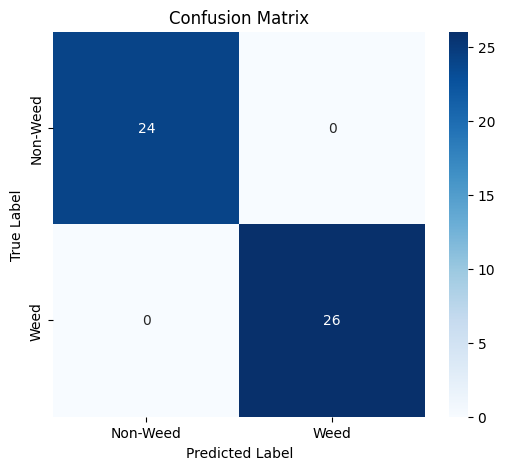


Classification Report:
              precision    recall  f1-score   support

    Non-Weed       1.00      1.00      1.00        24
        Weed       1.00      1.00      1.00        26

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [11]:
# Path for test dataset
TEST_IMAGE_PATH = r"/kaggle/working/Preprocessed_img_weed/test/images"
TEST_LABEL_PATH = r"/kaggle/working/Preprocessed_img_weed/test/labels"

# Loading the best trained model
model.student_model.load_state_dict(torch.load(r'/kaggle/working/best_model.pth'))
model.student_model = model.student_model.to(device)  
model.student_model.eval()

#---------------------------------------------------------------------------------------

# Defining the test dataset with labels using the new read_label_file method
class TestDatasetWithLabels(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.image_files)

    def read_label_file(self, label_path):
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
                lines = [line.strip() for line in lines if line.strip()]
                
                if not lines:
                    return 1 
                
                for line in lines:
                    parts = line.split()
                    if parts and parts[0] == '0':  
                        return 0  
                return 1  # Crop
        except Exception as e:
            print(f"Error reading label file {label_path}: {str(e)}")
            return 1
    
    def __getitem__(self, idx):
        """Fetch an image and its label."""
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))
        label = torch.tensor(self.read_label_file(label_path))  

        return image, label

# Defining test transform (same as validation)
test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = TestDatasetWithLabels(TEST_IMAGE_PATH, TEST_LABEL_PATH, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []

correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Test Accuracy"):
        images, labels = images.to(device), labels.to(device) 
        outputs = model.student_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Computing accuracy
test_accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Weed', 'Weed'], yticklabels=['Non-Weed', 'Weed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Weed', 'Weed'])) 

# **Observations**
*By simply fine-tuning a ResNet-50 model for classification task without using MTM method we achieved an accuracy of 74% on test dataset.*

*Without data augmentation on training set we achieved F1-Score of 0.98.*

*For 50 epochs we obtained accuracy of 98%.*

*With 100 epochs and appropriate data augmentation we achieved F1-Score of 1.*